#### **Welcome to Assignment 3 on Deep Learning for Vision.**


#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!


### Question 1: Resnet-18 from scratch

In this question, you'll have to code Resnet-18 from scratch (we have provided a lot of starter code), this'll help you get a hold on how to code an architecture with skip connections and blocks of layers.

It's suggested you first briefly understand how the Resnet architecture is defined originally before you start with this question. We do take inspiration from the original Pytorch implementation, but if you try peeking into the original source code in the library, it'll confuse you more than helping!

Train the model for 15 epochs. Report the train, test loss and accuracies. Also plot epochs vs loss. 

**Sidenote:** As this assignment is mainly focused on learning things, we train the models only for a small number of epochs and don't focus on hyper-parameter tuning. When you start using deep learning in real-world applications and competitions, hyper-parameter tuning plays a decent role!

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [22]:
# check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a set of transforms for preparing the dataset
transform_train = transforms.Compose([ transforms.ToTensor(),transforms.Normalize([0.4914,0.4822,0.4464],[0.2023,0.1994,0.2010]),transforms.RandomHorizontalFlip(),transforms.RandomCrop(size=32, padding=8)])

# use random crop with image size of 32 and padding of 8 
# flip the image horizontally (use pytorch random horizontal flip)
# convert the image to a pytorch tensor
# normalise the images with mean and std of the dataset 
# mean: (0.4914, 0.4822, 0.4465) std: (0.2023, 0.1994, 0.2010)


# define transforms for the test data: Should they be same as the one used for train? 
transform_test =  transforms.Compose([  transforms.ToTensor(),transforms.Normalize([0.4914,0.4822,0.4465],[0.2023,0.1994,0.2010])])  

# convert the image to a pytorch tensor
# normalise the images with mean and std of the dataset 
# mean: (0.4914, 0.4822, 0.4465) std: (0.2023, 0.1994, 0.2010)

use_cuda = True # if you have acess to a GPU, enable it to speed the training 

In [23]:
# Load the CIFAR-10 training, test datasets using `torchvision.datasets.CIFAR10`
#### YOUR CODE STARTS HERE ####
train_dataset = torchvision.datasets.CIFAR10(root=".",train=True, transform= transform_train, download =True)
test_dataset = torchvision.datasets.CIFAR10(root=".",train=False, transform= transform_train, download =True, )
#### YOUR CODE ENDS HERE ####

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=False)
#### YOUR CODE ENDS HERE ####

In [25]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    # define a convolutional layer with a kernel size of 3x3
    # use stride, groups values passed to the function along with a padding of 1 and dilatio of 1
    # set bias to False
    #### YOUR CODE STARTS HERE ####
    layer = nn.Conv2d(in_planes,out_planes,kernel_size=3,groups=groups, dilation=1, padding=1, bias=False,stride=stride)
    #### YOUR CODE ENDS HERE ####
    return layer


def conv1x1(in_planes, out_planes, stride=1):
    # define a convolutional layer with a kernel size of 1x1
    # use stride value passed to the function
    # set bias to False
    # leave all other parameters to default values
    #### YOUR CODE STARTS HERE ####
    layer = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,bias=False).cuda()
    #### YOUR CODE ENDS HERE ####
    return layer

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64):
        super(BasicBlock, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define batch-norm layer to for easy use (you don't have to call it here)
        norm_layer = nn.BatchNorm2d
        # define a 3x3 convolution layer with inplanes as in-channels and planes and out_channels, use the passed value of stride
        self.conv1 = conv3x3(inplanes,planes,stride=stride)
        # define a batchnorm layer (use the norm_layer defined above)
        self.bn1 = norm_layer(planes)
        # define a relu layer with inplace set to True
        self.relu = nn.ReLU(inplace=True)
        # define a 3x3 convolution layer with inplanes as in-channels and planes and out_channels
        self.conv2 = conv3x3(planes, planes)
        # define a batchnorm layer (use the norm_layer defined above)
        self.bn2 = norm_layer(planes)
        #### YOUR CODE ENDS HERE ####
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        # make a copy of nput (for using them in skip connections)
        
        identity = x
        out=self.conv1(x)
      
        out=self.bn1(out)
       
        out=self.relu(out)
        out=self.conv2(out)
      
        out=self.bn2(out)
        # pass the input through, conv1->bn1->relu->conv2->bn2
 
        #### YOUR CODE ENDS HERE ####

        if self.downsample is not None:
            identity = self.downsample(x)

        #### YOUR CODE STARTS HERE ####
        # add the skip connection
        
        out += identity
        # use a relu activation on `out`
        out= self.relu(out)
        #### YOUR CODE ENDS HERE ####

        return out

In [26]:
class ResNet18(nn.Module):
  # first start with make_layer method followed by __init__, forward methods
    def __init__(self, block, num_classes=10, groups=1):
        super(ResNet18, self).__init__()
        
        # define batch-norm layer to for easy use (you don't have to call it here)
        
        #### YOUR CODE STARTS HERE ####
        norm_layer = nn.BatchNorm2d

        #### YOUR CODE ENDS HERE ####
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = 64
        
        #### YOUR CODE STARTS HERE ####

        # define a conv layer with number of image channels as in-channels and inplanes ans out-channles,
        # use a kernel size of 7, stride of 2, padding of 3 and set bias to False 
        self.conv1 = nn.Conv2d(3, self.inplanes, stride =2 ,kernel_size =7, padding=3, bias= False )
        # define a batchnorm layer (use the norm_layer defined above)
        self.bn1 = self._norm_layer(self.inplanes)
        # define a relu layer with inplace set to True
        self.relu = nn.ReLU(inplace=True)
        # define a maxpool layer with kernel size of 3, stride of 2, padding of 1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # complete the make layer method below and use it with the block value passed to init
        # with 64 planes and 2 blocks
        self.layer1 = self._make_layer(block, planes=64, blocks=2)
        # use  make layer method to define a second set of layers with the block value passed to init
        # with 128 planes and 2 blocks and a stride value of 2
        self.layer2 = self._make_layer(block, planes=128 ,blocks=2, stride=2)
        # use  make layer method to define a second set of layers with the block value passed to init
        # with 256 planes and 2 blocks and a stride value of 2
        self.layer3 = self._make_layer(block, 256 ,blocks=2 , stride =2)
        # use  make layer method to define a second set of layers with the block value passed to init
        # with 512 planes and 2 blocks and a stride value of 2
        self.layer4 = self._make_layer(block, 512, blocks=2, stride =2)
        # define  adaptive avergae pooling layer with output size (1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        #### YOUR CODE ENDS HERE ####
        self.fc = nn.Linear(512 , 10)

        #### YOUR CODE STARTS HERE ####        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                
                # initialise the weights with kaiming normal, set mode to fan out and 
                # non_linearity to the activation function you used above

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.bias,0)
                nn.init.constant_(m.weight,1)
                # initialise weights with a value of 1 and bias with a value of 0
                
         #### YOUR CODE ENDS HERE ####

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            #### YOUR CODE STARTS HERE ####
            # append the blocks to layers, leave stride and downsample to default values
            layers.append(block(self.inplanes, planes,groups=self.groups,base_width=self.base_width))
            #### YOUR CODE ENDS HERE ####
        
        return nn.Sequential(*layers)

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        # complete the forward pass
        # order of layers: conv1->bn1->relu->maxpool->layer1->layer2->layer3->layer4->avgpool->fc

        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        
        x=self.avgpool(x)
        
        x=torch.flatten(x,1)
        x=self.fc(x)
        
        #### YOUR CODE ENDS HERE ####
        return x

In [27]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    
     #code added for plot
    
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target= data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output=model(data)
        # calculate the loss (use cross entropy in pytorch)
        Loss= torch.nn.CrossEntropyLoss()
        loss=Loss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
        
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    return(loss.item()) #added for plotting purpose
      

In [28]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:

          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data=data.to(device)
            target=target.to(device)
            # pass the image to the model and assign the output to variable named output
            output=model(data)
          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss #added for plotting purpose

In [29]:
model = ResNet18(BasicBlock, num_classes=10).to(device)
optimizer=optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss().cuda()
## Define Adam Optimiser with a learning rate of 0.01

start = timeit.default_timer()
#adding train and test loss list for plotting purpose
train_loss=[]
test_loss=[]
for epoch in range(0, 15):
    x=train(model, device, train_dataloader, criterion, optimizer, epoch) #added x and y;
    y=test(model, device, test_dataloader, criterion)
    train_loss.append(x)
    test_loss.append(y)
stop = timeit.default_timer()

print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.416355
Train Epoch: 0 [640/50000 (1%)]	Loss: 3.051997
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.448125
Train Epoch: 0 [1920/50000 (4%)]	Loss: 2.436611
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.535359
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.193045
Train Epoch: 0 [3840/50000 (8%)]	Loss: 2.247601
Train Epoch: 0 [4480/50000 (9%)]	Loss: 2.016618
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.302115
Train Epoch: 0 [5760/50000 (12%)]	Loss: 2.875909
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.747695
Train Epoch: 0 [7040/50000 (14%)]	Loss: 2.112700
Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.158101
Train Epoch: 0 [8320/50000 (17%)]	Loss: 2.001464
Train Epoch: 0 [8960/50000 (18%)]	Loss: 2.733909
Train Epoch: 0 [9600/50000 (19%)]	Loss: 2.088274
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.711751
Train Epoch: 0 [10880/50000 (22%)]	Loss: 2.372502
Train Epoch: 0 [11520/50000 (23%)]	Loss: 1.846898
Train Epoch: 0 [12160/50000 (24%)]	Loss: 2.024030
Train Epoch: 0 [12800/50000 

using same loss values as obtained by pre existing code*


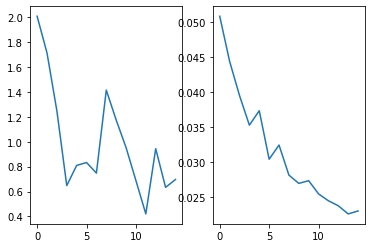

In [31]:
#this is added for plotting train and test loss
import matplotlib.pyplot as plt
print("using same loss values as obtained by pre existing code*")
plt.subplot(1,2,1)
plt.plot(range(0,15),train_loss)
plt.subplot(1,2,2)
plt.plot(range(0,15),test_loss)

### Question 2
Plot the saliency map from Pretrained Vgg19 model of the given image using "simple Gradient" method. Find out and print the mean and maximum  pixel intensity values of the generated saliency map. Note that the input image has 3 channels. To derive a single class saliency value for each pixel (i, j),  take the maximum magnitude across all colour channels.




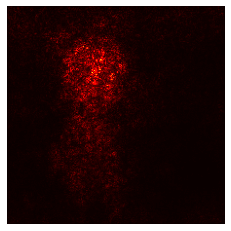

tensor(0.0173) mean
tensor(0.6645) max intensity


In [37]:
#IMPORTS
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Opening the image
img = Image.open('input.jpg')

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

### YOUR CODE STARTS HERE ###

model.eval()
X.requires_grad_()
score=model(X)
maximum_score_index= score. argmax()


maximum_score= score[0:,maximum_score_index]
maximum_score.backward()
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()
print(saliency.mean(), "mean")
print(saliency.max(),"max intensity")
### YOUR CODE ENDS HERE ###

### Question 3

Compute and print the accumulated Attribution over all the input pixels of the given image towards a class (class id-243) output using Integrated Gradient(IG) Method. Assume baseline or reference image to be an image with all zero pixels. Also consider number of steps in IG approximation as 5 and all intermediate step images should follow linear path from baseline image to original image.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


762.5184320348719


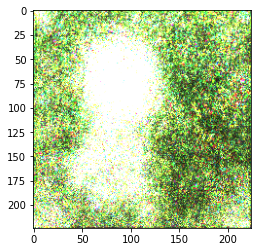

In [34]:
#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Opening the image
img = Image.open('input.jpg') 

# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

class IG():
    """
        Compute attribution of classifier's output from each input pixels using 
        Integrated Gradient Methood 
    """
    def __init__(self):
        self.model = torchvision.models.vgg19(pretrained=True) 
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def create_images_on_linear_path(self, input_image, steps):
        ''' Create list of all intermediate step images on a linear path
            conneting baseline image to original input image
        '''
        ### YOUR CODE STARTS HERE
    
        baseline = 0 * input_image 
        # scale inputs and compute gradients
        scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
        return scaled_inputs
        ### YOUR CODE ENDS HERE

    def compute_gradients(self, input_image, target_class):
        ''' Compute gradient of model's target class output w.r.t to all input pixels'''  

        ### YOUR CODE STARTS HERE
        score= self.model(input_image)
        input_image.retain_grad() 
        input_image.requires_grad_()
        grad_value=score[0:,target_class]
        grad_value.backward(retain_graph=True)
        return input_image.grad.data.abs().numpy()
        ### YOUR CODE ENDS HERE

    def compute_integrated_gradients(self, input_image, target_class, steps):

        ''' Main computation of Integrated Gradient method'''
        # Generate xbar images
        x_list = self.create_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
       
        for x_image in x_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.compute_gradients(x_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,224,224)
        return integrated_grads[0]

### YOUR CODE STARTS HERE
ans=IG()
attributions=ans.compute_integrated_gradients(input_image=X, target_class=243, steps=5)
print(attributions.sum())
attributions*=255
plt.imshow(np.moveaxis(attributions, 0, -1))
### YOUR CODE ENDS HERE

### Question 4

For the given input image, find out and print the channel index and the importance(weight) score of the most important feauture map (out of all the feature maps of final convolution layer of a pretrained ResNet50 model) using Grad-CAM method for the class prediction corresponding to "highest logit score". Note that, Grad-CAM produces final heatmap using the weighted combination of the feature map activations, where weights correspond to importance score.



Most important feature map index:  708
Its corresponding importance is:  0.0046336893


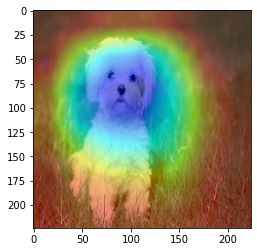

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models


def process_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    p_img = img.copy()[:, :, ::-1]
    for i in range(3):
        p_img[:, :, i] = p_img[:, :, i] - means[i]
        p_img[:, :, i] = p_img[:, :, i] / stds[i]
    p_img = np.ascontiguousarray(np.transpose(p_img, (2, 0, 1)))
    p_img = torch.from_numpy(p_img)
    p_img.unsqueeze_(0)
    input = p_img.requires_grad_(True)
    
    return input

class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    plt.imshow(img)


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        ### YOUR CODE STARTS HERE
      
        features, output = self.extractor(input)
        
        if index == None:
            index = np.argmax(output.data.numpy())

        output_onehot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        output_onehot[0][index] = 1
        output_onehot = torch.from_numpy(output_onehot).requires_grad_(True)
        output_onehot = output_onehot
        output_onehot = torch.sum(output_onehot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        
        output_onehot.backward(retain_graph=True)

        gradients = self.extractor.get_gradients()[-1].data.numpy()

        target = features[-1]
        target = target.data.numpy()[0, :]

        weights = np.mean(gradients, axis=(2, 3))[0, :]
        
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam -= np.min(cam)
        cam /= np.max(cam)
     
        return weights,cam
        
        ### YOUR CODE ENDS HERE


if __name__ == '__main__':
    
    image = cv2.imread('input.jpg', 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    input = process_image(image)

    net = models.resnet50(pretrained=True)
    grad_cam = GradientCam(model=net, feature_module=net.layer4, \
                       target_layer_=["2"], cuda=False)
    

    target_index = None

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50
   
    weights, class_activation_map = grad_cam(input, target_index)

    print ("Most important feature map index: ", np.argmax(weights))
    print ("Its corresponding importance is: ", np.max(weights))

    visualize(image, class_activation_map)